In [1]:
#libraries for entire process

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [3]:
# Load dataset function
def preprocess_data(data):
    # Handle missing values
    data['Date_of_Last_Visit'] = pd.to_datetime(data['Date_of_Last_Visit'], errors='coerce')
    data['Date_of_Surgery'] = pd.to_datetime(data['Date_of_Surgery'], errors='coerce')
    data['Time_Since_Surgery'] = (data['Date_of_Last_Visit'] - data['Date_of_Surgery']).dt.days.fillna(0)
    data['Patient_Status'] = data['Patient_Status'].fillna('Unknown')

    # Encode categorical variables
    categorical_columns = ['Gender', 'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status', 'Surgery_type', 'Patient_Status']
    for col in categorical_columns:
        data[col] = LabelEncoder().fit_transform(data[col])

    # Drop unnecessary columns
    data.drop(['Patient_ID', 'Date_of_Surgery', 'Date_of_Last_Visit'], axis=1, inplace=True)

    return data

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8076\2087176057.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date_of_Last_Visit'] = pd.to_datetime(data['Date_of_Last_Visit'], errors='coerce')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8076\2087176057.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date_of_Surgery'] = pd.to_datetime(data['Date_of_Surgery'], errors='coerce')


=== Classification Task ===
Classification Metrics:
Accuracy: 0.82
Precision: 0.68
Recall: 0.82
F1-Score: 0.75
ROC-AUC: 0.66


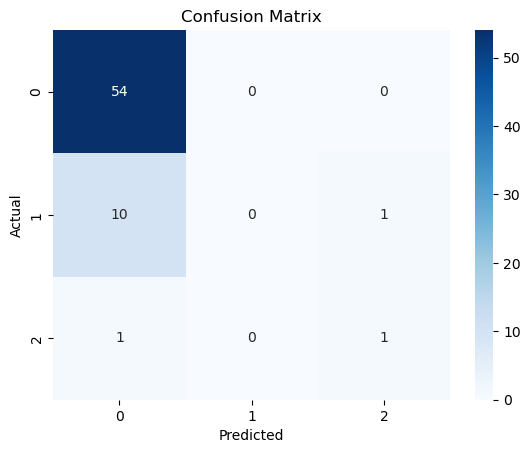

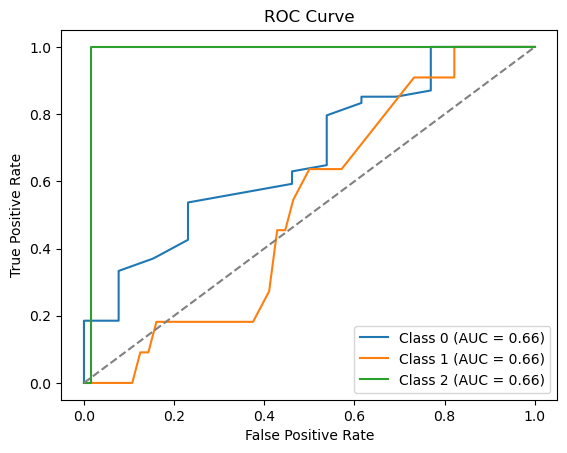


=== Clustering Task ===
Silhouette Score for Clustering: 0.09


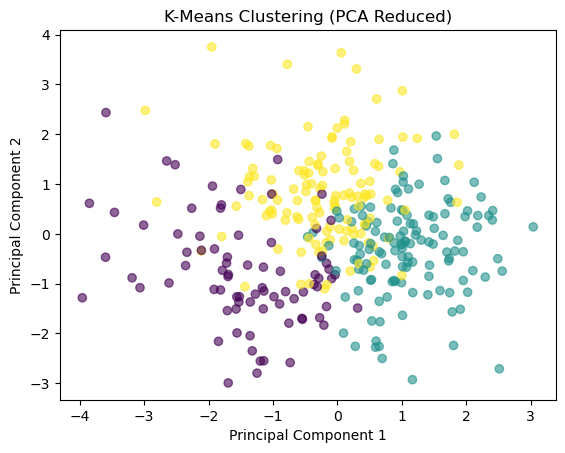

In [7]:
# Classification Task
def perform_classification(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Random Forest Classifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    # Evaluate Classification Model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Compute ROC AUC score
    if len(set(y)) > 2:  # Multi-class case
        y_test_binarized = label_binarize(y_test, classes=np.unique(y))
        roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr', average='weighted')
    else:  # Binary case
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    print("Classification Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    if len(set(y)) > 2:  # Multi-class case
        for i, class_label in enumerate(np.unique(y)):
            fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=np.unique(y))[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
    else:  # Binary case
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Clustering Task
def perform_clustering(X):
    # Apply KMeans Clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    # Evaluate Clustering
    sil_score = silhouette_score(X, clusters)
    print(f"Silhouette Score for Clustering: {sil_score:.2f}")
    
    # Visualize Clusters using PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    plt.title('K-Means Clustering (PCA Reduced)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Main Workflow
if __name__ == "__main__":
    # BRCA dataset read (changed the name as breast_cancer_data.csv for easiness of catching the content)
    data = pd.read_csv('breast_cancer_data.csv')
    data = preprocess_data(data)
    
    X = data.drop('Patient_Status', axis=1)
    y = data['Patient_Status']
    
    # Scale data for clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform Classification
    print("=== Classification Task ===")
    perform_classification(X_scaled, y)
    
    # Perform Clustering
    print("\n=== Clustering Task ===")
    perform_clustering(X_scaled)
